This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[[[130 540]
  [470 310]
  [485 320]
  [485 540]]]
3


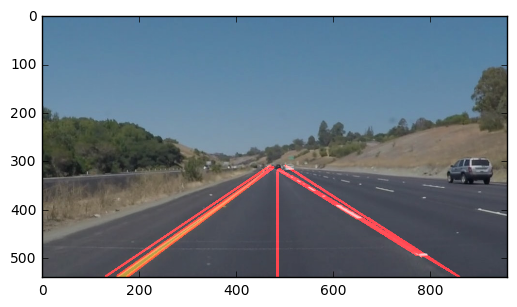

In [1]:
# Project 1: find lane lines and test on videos
# reference to CarND-LaneLines-P1/P1.ipynb
# importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from PIL import Image
#import pandas as pd
#import matplotlib.pylab as ply
#import statsmodels.api as sm
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error
#import statsmodels.formula.api as sm

#Populating the interactive namespace from numpy and matplotlib


# Import everything needed to edit/save/watch video clips

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def color_threshold(img, red_threshold, green_threshold, blue_threshold):

    red_threshold = 100
    green_threshold = 100
    blue_threshold = 100

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    # Perform a "bitwise or" to mask pixels below the threshold
    color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                       (image[:,:,1] < rgb_threshold[1]) | \
                       (image[:,:,2] < rgb_threshold[2])
            
    plt.imshow(color_thresholds)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[3]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (100, 100, 100) 
        
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once
    you want to average/extrapolate the line segments you detect to map out
    the full extent of the lane (going from the result shown in
    raw-lines-example.mp4 to that shown in P1_example.mp4).
    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.
    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
# linear regression not quite work in this case when the lines are not solid          
"""def linear_regression(img, rho, theta, threshold, min_line_len, max_line_gap, x_min, x_max):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    for line in lines:
        a = 0
        for x1, y1, x2, y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            if a == 0:
                a = np.matrix([[x1,y1],[x2,y2]])
            else:
                np.append(a,[[x1,y1],[x2,y2]])
            #print (a) 
    #add linear regression for the detected hough lines
    npMatrix = np.matrix(a)       
    X, Y = npMatrix[:,0], npMatrix[:,1]
    mdl = LinearRegression().fit(X,Y)
    m = mdl.coef_[0]
    b = mdl.intercept_
    print (a)
    print (m)
    print (b)
    plt.plot([x_min, x_max],[b, m*x_max+b],"r")
    return (m,b)"""
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype = np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    `initial_img` should be the image before any processing.
    The result image is computed as follows:
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image(image):
    # printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    gray = grayscale(image)
    
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    # plt.imshow(blur_gray, cmap='gray')
    
    
            
    #plt.imshow(color_thresholds)
    #vertices = np.array([[(0,imshape[0]),(450, 312), (490, 312), (imshape[1],imshape[0])]], dtype=np.int32)  
    #the processed image will stuck at different persentage due to change of mask size, adjusting parameters of hough line also affects
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    
    vertices_left = np.array([[(130, imshape[0]),(470, 310), (485, 320), (485, imshape[0])]], dtype=np.int32) 
    vertices_right = np.array([[(485, imshape[0]),(485, 320), (500, 310), (860, imshape[0])]], dtype=np.int32) 
    print(vertices_left)
    #masked_edges = region_of_interest(edges, vertices)
    masked_image_left = region_of_interest(blur_gray, vertices_left)
    
    masked_image_right = region_of_interest(blur_gray, vertices_right)
    cropped = blur_gray[70:500, 400:800]
    
    #img2 = image.crop((0, 0, 100, 100))
    plt.imshow(cropped)
    #plt.imshow(masked_image_left)
    
    # Define parameters for Canny and apply
    low_threshold = 70 
    high_threshold = 210 
    imshape= masked_image_left.shape
    #plt.imshow(masked_image_left)
    edges_left = canny(masked_image_left, low_threshold, high_threshold)
    
    imshape = masked_image_right.shape
    edges_right = canny( masked_image_right, low_threshold, high_threshold)
    print(len(image.shape))
    plt.imshow(edges_right)
    
   
   
    #plt.imshow(masked_edges_left)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 25    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50 #minimum number of pixels making up a line over 40 doesn't work
    max_line_gap = 130 # maximum gap in pixels between connectable line segments, less is better
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    lines = (hough_lines(edges_left, rho, theta, threshold, min_line_length, max_line_gap) + 
    hough_lines(edges_right, rho, theta, threshold, min_line_length, max_line_gap))
    # Draw the lines on the edge image
    lines_edges = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return lines_edges

def process_image_challenge(image):
    # printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    gray = grayscale(image)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    # plt.imshow(blur_gray, cmap='gray')
    # Define color selection criteria
    # MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
    
    # Define our parameters for Canny and apply
    low_threshold = 50 
    high_threshold = 150 
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    
    #vertices = np.array([[(0,imshape[0]),(450, 312), (490, 312), (imshape[1],imshape[0])]], dtype=np.int32)  
    #the processed image will stuck at different persentage due to change of mask size, adjusting parameters of hough line also affects
    
    vertices_left = np.array([[(200, imshape[0]-40),(685, 410), (700, 420), (700, (imshape[0]-80))]], dtype=np.int32) 
    vertices_right = np.array([[(700, imshape[0]-80),(715, 420), (715, 410), (970, imshape[0]-40)]], dtype=np.int32) 
    masked_edges_left = region_of_interest(edges, vertices_left)
    masked_edges_right = region_of_interest(edges, vertices_right)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 35   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line over 40 doesn't work
    max_line_gap = 60 # maximum gap in pixels between connectable line segments, less is better
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    lines = (hough_lines(masked_edges_left, rho, theta, threshold, min_line_length, max_line_gap) + 
    hough_lines(masked_edges_right, rho, theta, threshold, min_line_length, max_line_gap))
    # Draw the lines on the edge image
    lines_edges = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return lines_edges

def main():
    # testing on image
    image = mpimg.imread('solidYellowCurve.jpg')
    processImage = process_image(image)
    plt.imshow(processImage)
    plt.show()

    """#video 1 test
    white_right_output = 'white_right.mp4'
    clip1 = VideoFileClip("solidWhiteRight.mp4")
    white_right_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    white_right_clip.write_videofile(white_right_output, audio=False)

    # video 2 test
    yellow_left_output = 'yellow_left.mp4'
    clip2 = VideoFileClip('solidYellowLeft.mp4')
    yellow_left_clip = clip2.fl_image(process_image)
    yellow_left_clip.write_videofile(yellow_left_output, audio=False)
    
    video challenge test
    video_challenge_output = 'video_challenge.mp4'
    clip2 = VideoFileClip('challenge.mp4')
    video_challenge_clip = clip2.fl_image(process_image_challenge)
    video_challenge_clip.write_videofile(video_challenge_output, audio=False)
    random consensus
    angle filter
    """

    
if __name__ == '__main__':
    main()
    